# iModulon activity blocks by CIP time

Load `Eco_CIP_A_50.csv`, rename columns into four 10k-sample blocks (CIP 0h/1h/2h/4h), and plot a component's activities with color-coded bars and group separators.

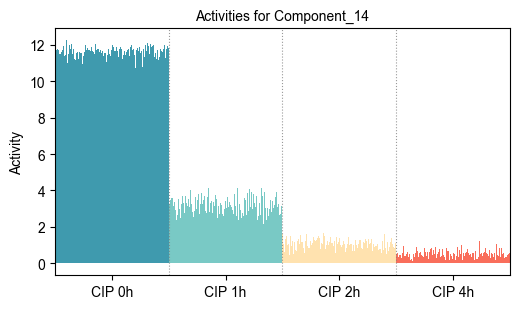

In [11]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

data_dir = Path("Data")
A_path = data_dir / "Eco_CIP_A_50.csv"
component = "Component_14"  # change to the component you want to visualize
fig_size = (5.3, 3.2)          # adjust to control SVG size
downsample_stride = 10      # number of samples to average together (>=1)
font_path = "/usr/share/fonts/truetype/msttcorefonts/Arial.ttf"
output_path = Path("Paper_Figures/Single_Cell_iM_Translation_Activity.svg")

# Load activities
A = pd.read_csv(A_path, index_col=0)
n_samples = A.shape[1]
expected = 40000
if n_samples < expected:
    raise ValueError(f"Expected at least {expected} samples (4x10k), found {n_samples}")

# Build new column names for four 10k blocks
block_size = 10_000
blocks = [
    (0, block_size, "CIP_0h"),
    (block_size, 2 * block_size, "CIP_1h"),
    (2 * block_size, 3 * block_size, "CIP_2h"),
    (3 * block_size, 4 * block_size, "CIP_4h"),
]

new_cols = []
colors_full = []
palette = {
    "CIP_0h": "#3F9AAE",
    "CIP_1h": "#79C9C5",
    "CIP_2h": "#FFE2AF",
    "CIP_4h": "#F96E5B",
}

for start, end, label in blocks:
    for idx in range(start, end):
        new_cols.append(f"{label}_{idx - start + 1:05d}")
        colors_full.append(palette[label])

A.columns = new_cols

# Extract component activities
if component not in A.index:
    raise KeyError(f"Component '{component}' not found. Available: {list(A.index)[:5]} ...")
activity_full = A.loc[component].to_numpy()

# Downsample by averaging consecutive bins within each block to reduce SVG size
agg_activity = []
agg_colors = []
block_lengths_ds = []
stride = max(1, int(downsample_stride))
cursor = 0
for start, end, label in blocks:
    block_vals = activity_full[start:end]
    block_len = len(block_vals)
    usable = (block_len // stride) * stride
    block_vals = block_vals[:usable]
    if usable == 0:
        continue
    block_agg = block_vals.reshape(-1, stride).mean(axis=1)
    agg_activity.append(block_agg)
    agg_colors.extend([palette[label]] * len(block_agg))
    block_lengths_ds.append(len(block_agg))
    cursor += len(block_agg)

agg_activity = np.concatenate(agg_activity) if agg_activity else np.array([])

# Prepare plotting grid
x = np.arange(len(agg_activity))
font_prop = fm.FontProperties(fname=font_path) if Path(font_path).exists() else None

fig, ax = plt.subplots(figsize=fig_size)

# Draw slim bars (width=1) for each aggregated sample
ax.bar(x, agg_activity, color=agg_colors, width=1.0, linewidth=0)

# Vertical dotted separators between blocks (after downsampling)
boundaries = np.cumsum(block_lengths_ds)[:-1]
for boundary in boundaries:
    ax.axvline(boundary - 0.5, color="gray", linestyle=":", linewidth=0.8, alpha=0.8)

# Group ticks at block centers
centers = []
pos = 0
for length in block_lengths_ds:
    centers.append(pos + length / 2)
    pos += length
labels = ["CIP 0h", "CIP 1h", "CIP 2h", "CIP 4h"][: len(centers)]
ax.set_xticks(centers)
ax.set_xticklabels(labels, fontproperties=font_prop)

ax.set_xlim(-0.5, len(agg_activity) - 0.5)
ax.set_ylabel("Activity", fontproperties=font_prop)
ax.set_title(f"Activities for {component}", fontproperties=font_prop)
ax.tick_params(axis="x", rotation=0)
if font_prop:
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontproperties(font_prop)
    ax.yaxis.label.set_fontproperties(font_prop)

plt.tight_layout()

# Save SVG with controlled size
output_path.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(output_path, format="svg", bbox_inches="tight")

plt.show()
